In [6]:
!pip install umap-learn
!pip install imageio
!pip install matplotlib

In [7]:
import json
from pathlib import Path
from datetime import datetime, timezone
from sklearn.decomposition import TruncatedSVD
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import imageio
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sevskii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data_path = Path('prod/news/')

In [9]:
all_data_references = [str(i) for i in list(data_path.glob('**/*.json'))]

In [10]:
all_data_dict = list()

for path in all_data_references:
  with open(path, 'r') as f:
    all_data_dict += json.load(f)

In [11]:
for obj in all_data_dict:
  obj['timestamp'] = datetime.fromisoformat(obj['timestamp']).astimezone(timezone.utc)

In [12]:
all_data_dict.sort(key=lambda x: x['timestamp'])

In [13]:
content_list = []
tags = []
dates = []
for i in all_data_dict:
    string_content = f"{i['title']} {i['text']}"
    tags.append(', '.join(i['tags']))
    dates.append(i['timestamp'])
    content_list.append(string_content)

In [14]:
import pandas as pd

In [15]:
news_df = pd.DataFrame({'document': content_list, 'tags': tags, 'dates': dates})

In [16]:
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Zа-яА-Я#]", " ")
news_df = news_df[news_df['clean_doc'].notnull()]
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/var/folders/dl/2bkd188s3y1c1xz6fdd4plr40000gn/T/ipykernel_7086/1881652931.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Zа-яА-Я#]", " ")


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
russian_stopwords = stopwords.words("russian")
english_stopwords = stopwords.words('english')
stop_words = russian_stopwords + english_stopwords
stop_words.extend('interfax.ru')
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = vectorizer.fit_transform(news_df['clean_doc'])
terms = vectorizer.get_feature_names()

/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
from sklearn.cluster import KMeans
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(X)
clusters = km.labels_.tolist()

In [20]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X, n_components=num_clusters, n_iter=100,
                              random_state=122)

In [21]:
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x: x[1], reverse=True)[:7]
        print("Concept "+ str(i) +": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

Concept 0: 
года
млрд
россии
рублей
также
году
пресс
 
Concept 1: 
млрд
рублей
млрд рублей
года
баррель
акций
нефти
 
Concept 2: 
covid
случаев
сутки
число
заражения
коронавирусом
коронавируса
 
Concept 3: 
рублей
млрд
млрд рублей
области
случаев
человек
covid
 
Concept 4: 
баррель
нефть
нефти
дело
brent
евро
торгов
 
Concept 5: 
матче
сборной
цска
место
команды
лиги
чемпионата
 
Concept 6: 
рублей
колонии
дело
суда
делу
дела
отношении
 
Concept 7: 
рублей
млрд рублей
млрд
области
песков
украины
путин
 
Concept 8: 
области
года
сутки
газа
тонн
россии
случаев
 
Concept 9: 
акции
акций
индекс
мосбиржи
пункта
бумаги
индекс мосбиржи
 


/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


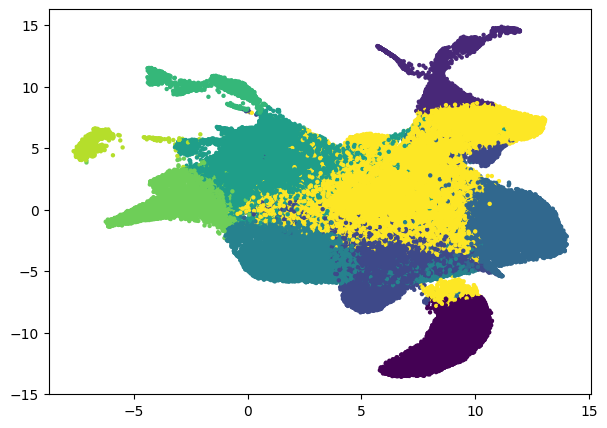

In [22]:
import umap
X_topics=U*Sigma
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)
plt.figure(figsize=(7, 5))
plt.scatter(embedding[:, 0], 
            embedding[:, 1], 
            c = clusters,
            s = 10, # size
            edgecolor='none'
            )
plt.show()

In [23]:
def get_top_tf_idf_words(response, top_n=2):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return np.array(terms)[response.indices[sorted_nzs]]

In [24]:
window_len = pd.to_timedelta(2, unit='w')
step = pd.to_timedelta(1, unit='w')
window_start = news_df.dates[0]
filenames = []

curr_centers = None

for file_i in range(10):
  window_mask = (news_df.dates >= window_start) & (news_df.dates < (window_start + window_len))
  plt.figure(figsize=(7, 5))

  if curr_centers is None:
    km = KMeans(n_clusters=num_clusters)
  else:
    km = KMeans(n_clusters=num_clusters, init=curr_centers)
  km.fit(embedding[window_mask])
  curr_centers = km.cluster_centers_
  
  clusters = km.labels_

  
  for i in range(num_clusters):
    cluster_center = embedding[window_mask][clusters == i].mean(0)

    windowed_docs = []
    for j, k in enumerate(range(np.where(window_mask)[0][0], np.where(window_mask)[0][-1])):
      if clusters[j] == i:
        windowed_docs.append(news_df['clean_doc'][k])

    vectorized_windowed_docs = vectorizer.transform(windowed_docs)

    plt.scatter(embedding[window_mask][clusters == i, 0], 
            embedding[window_mask][clusters == i, 1], 
            s = 10, # size
            edgecolor='none',
            label=set(get_top_tf_idf_words(vectorized_windowed_docs, 10))
            )
    
    plt.scatter(cluster_center[0], cluster_center[1], c='r', marker='x', s=50)


  filename = f'{file_i}.png'
  filenames.append(filename)

  plt.legend(bbox_to_anchor=(1, 0.5))
  #plt.show()
  plt.xlim((-10, 15))
  plt.ylim((-10, 20))
  plt.savefig(filename, bbox_inches='tight')
  plt.close()
  window_start += step
  

/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._

In [25]:
# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        for _ in range(10):
          writer.append_data(image)

/var/folders/dl/2bkd188s3y1c1xz6fdd4plr40000gn/T/ipykernel_7086/3685853124.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [39]:
km.fit(embedding)

/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


KMeans(init=array([[  6.0162277 ,  -1.1161155 ],
       [  8.687877  ,  11.619227  ],
       [  0.77283335,   4.784663  ],
       [  6.656076  ,   2.9093616 ],
       [  8.651253  , -10.079327  ],
       [ 11.403872  ,  -1.2343429 ],
       [  0.16208696,   0.7533132 ],
       [ 10.259025  ,   7.005907  ],
       [  3.4058867 ,  -3.9706354 ],
       [ -3.007235  ,   8.687322  ]], dtype=float32),
       n_clusters=10)

In [40]:
# это вручную выбранные кластеры которые относятся к бизнес теме
business_mask = (km.labels_ == 2) | (km.labels_ == 6) | (km.labels_ == 9)

In [41]:
news_df_b = news_df[business_mask]

In [43]:
svd_b = TruncatedSVD(n_components=num_clusters, n_iter=100,
                              random_state=122)

In [44]:
X_topics_b = svd_b.fit_transform(X[business_mask])
u = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12)
embedding_b = u.fit_transform(X_topics_b)

In [30]:
doc_b = []
for i, m in enumerate(business_mask):
  if m:
    doc_b.append(news_df['clean_doc'][i])

In [45]:
window_len_b = pd.to_timedelta(2, unit='w')
step_b = pd.to_timedelta(1, unit='w')
window_start_b = news_df_b.dates.iloc[0]
filenames_b = []

curr_centers = None

for file_i in range(30):
  window_mask = (news_df_b.dates >= window_start_b) & (news_df_b.dates < (window_start_b + window_len_b))
  plt.figure(figsize=(7, 5))

  if curr_centers is None:
    km = KMeans(n_clusters=num_clusters)
  else:
    km = KMeans(n_clusters=num_clusters, init=curr_centers)
  km.fit(embedding_b[window_mask])
  curr_centers = km.cluster_centers_
  
  clusters = km.labels_

  
  for i in range(num_clusters):
    cluster_center = embedding_b[window_mask][clusters == i].mean(0)

    windowed_docs = []
    for j, k in enumerate(range(np.where(window_mask)[0][0], np.where(window_mask)[0][-1])):
      if clusters[j] == i:
        windowed_docs.append(doc_b[k])

    vectorized_windowed_docs = vectorizer.transform(windowed_docs)

    plt.scatter(embedding_b[window_mask][clusters == i, 0], 
            embedding_b[window_mask][clusters == i, 1], 
            s = 10, # size
            edgecolor='none',
            label=set(get_top_tf_idf_words(vectorized_windowed_docs, 10))
            )
    
    plt.scatter(cluster_center[0], cluster_center[1], c='r', marker='x', s=50)


  filename = f'{file_i}_b.png'
  filenames_b.append(filename)

  plt.legend(bbox_to_anchor=(1, 0.5))
  #plt.show()
  plt.title(window_start_b)
  plt.xlim((-5, 20))
  plt.ylim((-10, 25))
  plt.savefig(filename, bbox_inches='tight')
  plt.close()
  window_start_b += step
  

/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
/opt/homebrew/Caskroom/miniforge/base/envs/vtb_hack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._

In [46]:
# build gif
with imageio.get_writer('mygif_b.gif', mode='I') as writer:
    for filename in filenames_b:
        image = imageio.imread(filename)
        for _ in range(1):
          writer.append_data(image)

/var/folders/dl/2bkd188s3y1c1xz6fdd4plr40000gn/T/ipykernel_7086/2927910884.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [48]:
import pickle

with open('vectorizer.pth', 'wb') as vectorizer_file:
  pickle.dump(vectorizer, vectorizer_file)

with open('svd.pth', 'wb') as svd_file:
  pickle.dump(svd_b, svd_file)

with open('u.pth', 'wb') as u_file:
  pickle.dump(u, u_file)